# A benchmark for time-frequency denoising/ detecting methods

## What is this benchmark?
A benchmark is a comparison between different methods when running an standardized test. The goal of this benchmark is to compare different methods for denoising / detecting a signal based on different characterizations of the of the time-frequency representation of the signal. This particular benchmark has been created for evaluating the performance of techniques based on the zeros of the spectrogram and to contrast them with more traditional methods, like those based on the ridges of that time-frequency distribution.

Nevertheless, with the purpose of making this benchmark more useful, the methods to compare, the tests, and the performance evaluation functions were conceived as different modules, so that one can assess new methods without modifing the tests. The only restriction this pose is that the methods should satisfy some requirements regarding the shape of their input an output parameters.  On the one hand, the tests and the performance evaluation functions, are encapsulated in the class `Benchmark`. On the other hand, the signals used in this benchmark are generated by the methods in the class `SignalBank`.

In order to compare different methods with possibly different parameters, we need to set up a few things before running the benchmark. A `Benchmark` object receives some input parameters to configure the test:
- `task`: This could be `'denoising'` or `'detecting'`. The first one compute the quality reconstruction factor (QRF) using the output of the method, whereas the second simply consist in detecting whether a signal is present or not.
- `N`: The length of the simulation, i.e. how many samples should the signals have.
- `methods`: A dictionary of methods. Each entry of this dictionary corresponds to the function that implements each of the desired methods.
- `parameters`: A dictionary of parameters. Each entry of this dictionary corresponds to an array of tuples to pass as input parameters to each method. In order to know which parameters should be passed to each methods, the keys of this dictionary should be the same as those corresponding to the individual methods in the corresponding dictionary. An example of this is showed below.
- `SNRin`: A list or tuple of values of SNR to test.
- `repetitions`: The number of times the experiment should be repeated with different realizations of noise.

## A dummy test 
First let us define a dummy method for testing. Methods should receive an `M`x`N` numpy array of noisy signals, where `M` is the number of signals, and `N` is the number of their time samples. Additionally, they should receive a second parameter `params` to allow testing different combinations of input parameters. The shape of the output depends on the task (denoising or detecting). So the signature of a method should be the following:

 `output = a_method(noisy_signals,params) `.

If one set `task='denoising'`, `output` should be also a `M`x`N` numpy array, i.e. the same shape as the input parameter `noisy_signals`, whereas if `task='detecting'`, the output should be boolean (`0` or `False` for no signal, and `1` or `True` otherwise).

After this, we need to create a *dictionary of methods* to pass the `Benchmark` object at the moment of instantiation.

In [1]:
import numpy as np
from numpy import pi as pi
import pandas as pd
from matplotlib import pyplot as plt
from benchmark_demo.Benchmark import Benchmark
from benchmark_demo.ResultsInterpreter import ResultsInterpreter

def a_method(noisy_signals, params):
    # If additional input parameters are needed, they can be passed in a tuple using `params` and then parsed.
    results = noisy_signals # Simply return the same noisy signals.
    return results

def another_method(noisy_signals, params):
    # If additional input parameters are needed, they can be passed in a tuple using `params` and then parsed.
    results = 2*noisy_signals # Simply return the same noisy signals.
    return results

# Create a dictionary of the methods to test.
my_methods = {
    'Method 1': a_method, 
    'Method 2': another_method,
    }

The variable `params` in the example above allows us to pass some parameters to our method. This would be useful for testing a single method with several combination of input parameters. In order to do this, we should give the `Benchmark` object a *dictionary of parameters*. An example of this functionality is showed in the next section. For now, lets set the input parameter `parameters = None`.

Now we are ready to instantiate a `Benchmark` object and run a test using the proposed methods and parameters. The benchmark constructor receives a name of a task (which defines the performance function of the test), a dictionary of the methods to test, the desired length of the signals used in the simulation, a dictionary of different parameters that should be passed to the methods, an array with different values of SNR to test, and the number of repetitions that should be used for each test. Once the object is created, use the class method `run_test()` to start the experiments.

*Remark 1: You can use the ```verbosity``` parameter to show less or more messages during the progress of the experiments. There are 4 levels of verbosity, from ```verbosity=0``` (indicate just the start and the end of the experiments) to ```verbostiy = 4``` (show each method and parameter progress)*

*Remark 2: Parallelize the experiments is also possible by passing the parameter ```parallelize = True```. *

In [2]:
benchmark = Benchmark(task = 'denoising',
                        methods = my_methods,
                        N = 256,
                        parameters = None, 
                        SNRin = [40,50], 
                        repetitions = 3,
                        using_signals=['LinearChirp', 'CosChirp',],
                        verbosity=4, 
                        parallelize=False)
                        
benchmark.run_test() # Run the test. my_results is a dictionary with the results for each of the variables of the simulation.

Running benchmark...
- Signal LinearChirp
-- SNR: 40 dB
--- Method: Method 1
--- Method: Method 2
-- SNR: 50 dB
--- Method: Method 1
--- Method: Method 2
- Signal CosChirp
-- SNR: 40 dB
--- Method: Method 1
--- Method: Method 2
-- SNR: 50 dB
--- Method: Method 1
--- Method: Method 2
The test has finished.


{'LinearChirp': {40: {'Method 1': {'0': array([39.99896987, 39.99896987, 39.99896987])},
   'Method 2': {'0': array([-0.01755568, -0.01148953,  0.02380659])}},
  50: {'Method 1': {'0': array([49.98970876, 49.98970876, 49.98970876])},
   'Method 2': {'0': array([ 0.00305747, -0.00261806,  0.00500734])}}},
 'CosChirp': {40: {'Method 1': {'0': array([39.99969033, 39.99969033, 39.99969033])},
   'Method 2': {'0': array([ 0.02979652, -0.01550776, -0.01139779])}},
  50: {'Method 1': {'0': array([49.99690403, 49.99690403, 49.99690403])},
   'Method 2': {'0': array([-0.00544775,  0.0012584 , -0.00142888])}}}}

Now we have the results of the test in a nested dictionary called `my_results`. In order to get the results in a human-readable way using a `DataFrame`, and also for further analysis and reproducibility, we can use the class method `get_results_as_df()`.

In [3]:
results_df = benchmark.get_results_as_df() # This formats the results on a DataFrame
results_df

,Method,Parameter,Signal_id,Repetition,40,50
6,Method 1,0,CosChirp,0,39.999690,49.996904
7,Method 1,0,CosChirp,1,39.999690,49.996904
8,Method 1,0,CosChirp,2,39.999690,49.996904
0,Method 1,0,LinearChirp,0,39.998970,49.989709
1,Method 1,0,LinearChirp,1,39.998970,49.989709
2,Method 1,0,LinearChirp,2,39.998970,49.989709
9,Method 2,0,CosChirp,0,0.029797,-0.005448
10,Method 2,0,CosChirp,1,-0.015508,0.001258
11,Method 2,0,CosChirp,2,-0.011398,-0.001429
3,Method 2,0,LinearChirp,0,-0.017556,0.003057


As we can see, the DataFrame show the results ordered by columns. The first column corresponds to the method identification, and the values are taken from the keys of the dictionary of methods. The second column enumerates the parameters used (more on this on the next section). The third column corresponds to the signal identification, using the signal identification values from the `SignalBank` class. The next column shows the number of repetition of the experiment. Finally, the remaining columns show the results obtained for the SNR values used for each experiment. Since `task = 'denoising'`, these values correspond to the QRF computed as `QRF = 10*np.log10(E(s)/E(s-sr))`, where `E(x)` is the energy of `x`, and `s` and `sr` are the noiseless signal and the reconstructed signal respectively.

## Passing different parameters to the methods.
It is common that a method depends on certain input parameters (thresholds, multiplicative factors, etc). Therefore, it would be useful that the tests could also be repeated with different parameters, instead of creating multiple versions of one method. We can pass an array of parameters to a method provided it parses them internally. In order to indicate the benchmark which parameters combinations should be given to each method, a dictionary of parameters can be given. 

Let us now create this dictionary. The parameters combinations should be given in a tuple of tuples, or a numpy array, so that each internal tuple, or row of the array, is passed as the additional parameter `param` of the method (this latter should implement how to distribute the parameters from this tuple). For this to work, **the keys of this dictionary should be the same as those of the methods dictionary**. 

We can now see more in detail how to pass different parameters to our methods. For instance, let's consider a function that depends on two thresholds `thr1` and `thr2`:

In [4]:
def a_function(signal, thr1, thr2):
    signal_out = signal
    signal_out[np.where((thr2>signal) & (signal>thr1))] = 1
    return signal_out

Now let us create a method that wraps the previous function and then define the dictionary of methods for our benchmark. Notice that the method should distribute the parameters in the tuple `params`. 

In [5]:
def another_method(noisy_signals, params):
    output_signals = np.zeros(noisy_signals.shape)
    # The method should distribute the parameters accordingly, for example as:
    thr1 = params[0]
    thr2 = params[1]
    
    output = [a_function(signal, thr1, thr2) for signal in noisy_signals]
    output = np.array(output)
    return output
        

# Create a dictionary of the methods to test.
my_methods = {
    'Method 1': another_method, 
    }

Having done this, we can define the different combinations of parameters using the corresponding dictionary:

In [6]:
# Create a dictionary of the different combinations of thresholds to test:
thr1 = [0.1, 0.3, 0.5] # Some values for the thresholds.
thr2 = np.arange(4,6,1)

my_parameters = {
    'Method 1': [[t1,t2] for t1 in thr1 for t2 in thr2], # Remember the keys of this dictionary should be same as the methods dictionary.
}

print((my_parameters['Method 1']))

[[0.1, 4], [0.1, 5], [0.3, 4], [0.3, 5], [0.5, 4], [0.5, 5]]


So now we have four combinations of input parameters for `another_method()`, that will be passed one by one to the method so that all the experiments will be carried out for each of the combinations. Let us set the benchmark and run a test using this new configuration of methods and parameters. After that, we can use the `Benchmark` class method `get_results_as_df()` to obtain a table with the results as before:

In [7]:
benchmark_p = Benchmark(task = 'denoising',
                         methods = my_methods, 
                         N = 256, 
                         parameters = my_parameters, 
                         SNRin = [40,50],
                         using_signals=['LinearChirp', 'CosChirp',], 
                         repetitions = 3)

benchmark_p.run_test() # Run the test. my_results is a dictionary with the results for each of the variables of the simulation.
results_parameters = benchmark_p.get_results_as_df() # This formats the results on a DataFrame
results_parameters

Running benchmark...
The test has finished.


,Method,Parameter,Signal_id,Repetition,40,50
3,Method 1,"[0.1, 4]",CosChirp,0,5.810911,5.811786
4,Method 1,"[0.1, 4]",CosChirp,1,5.810889,5.811788
5,Method 1,"[0.1, 4]",CosChirp,2,5.810859,5.811781
0,Method 1,"[0.1, 4]",LinearChirp,0,7.495571,7.496916
1,Method 1,"[0.1, 4]",LinearChirp,1,7.495481,7.496923
2,Method 1,"[0.1, 4]",LinearChirp,2,7.495485,7.496913
9,Method 1,"[0.1, 5]",CosChirp,0,5.810911,5.811786
10,Method 1,"[0.1, 5]",CosChirp,1,5.810889,5.811788
11,Method 1,"[0.1, 5]",CosChirp,2,5.810859,5.811781
6,Method 1,"[0.1, 5]",LinearChirp,0,7.495571,7.496916


As we can see, the experiments have been repeated for every combination of parameters, listed in the second column of the table as `Param#`, where `#` is the number corresponding to one group of input parameters.

## Generating plots with the Results Interpreter.

LinearChirp
CosChirp


C:\Users\juan_\Nextcloud\Miramont_Juan\python_code\benchmark-demo\src\benchmark_demo\ResultsInterpreter.py:78: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df3 = df3.drop('level_1', 1)
C:\Users\juan_\Nextcloud\Miramont_Juan\python_code\benchmark-demo\src\benchmark_demo\ResultsInterpreter.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux.loc[indexes,'Method'] = df_aux.loc[indexes,'Method'] +'-'+ df_aux.loc[indexes,'Parameter']
C:\Users\juan_\Nextcloud\Miramont_Juan\python_code\benchmark-demo\src\benchmark_demo\ResultsInterpreter.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

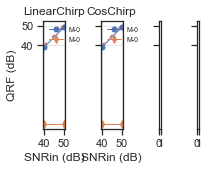

In [10]:
interpreter = ResultsInterpreter(benchmark)

fig = interpreter.get_summary_grid(savetofile=False)
plt.show()
